## libs

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import itertools  

In [2]:
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.stats import norm
from scipy.signal import savgol_filter
import scipy.integrate as integrate
from scipy.stats import kde as kde_stats

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from tqdm import tqdm_notebook

## initialization

In [4]:
STARS_DIRECTORY = Path('../clusters_mem/')
MAIN_DIRECTORY = Path('../')
PLOTS_DIRECTORY = Path ('../plots/')
ISOCHRONES_DIRECTORY = Path ('../isochrones/')

In [5]:
CLUSTER = 'NGC_2516'

In [6]:
def read_file(filename):
    df = pd.read_csv(filename, delimiter='\\s+')
    df = df.apply(pd.to_numeric, errors='coerce')
    try:
        df.dropna(subset = ['phot_g_mean_mag','bp_rp'], inplace = True)
    except:
        pass
    return df

In [7]:
all_stars = pd.read_hdf(STARS_DIRECTORY / f'{CLUSTER}.h5', delimiter=',')

## cutting off stars in the interval

In [8]:
mask_probability = (all_stars['P_tot'] > 0)

stars = all_stars[mask_probability].copy()
stars['phot_color_mag'] = stars['phot_bp_mean_mag'] - stars['phot_rp_mean_mag']

In [174]:
0.13 - (stars['BP_RP'] - stars['phot_color_mag']).mean()

0.24811318035991403

In [9]:
mask_color = (stars['phot_color_mag'] > 0.2) & (stars['phot_color_mag'] < 1.75)

stars = stars[mask_color]

In [10]:
# #optional
mask_turnoff = (stars['phot_g_mean_mag'] > 8)

stars = stars[mask_turnoff]

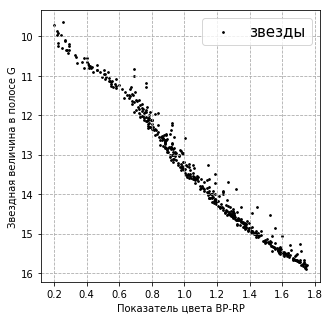

In [11]:
fig, ax = plt.subplots(figsize=(5,5 ))
ax.scatter (stars['phot_color_mag'] , stars['phot_g_mean_mag'] , c ='black', s = 3, label ='звезды')

ax.grid(c='#aaaaaa', ls='--') 
locs, labels = plt.yticks()
locs, labels = plt.xticks()
ax.invert_yaxis()

plt.xlabel('Показатель цвета BP-RP')
plt.ylabel('Звездная величина в полосе G')
ax.tick_params(axis='both', which='major')
ax.legend(fontsize = 15)


In [12]:
def create_isochrone(stars, k_del, order):
    # create data
    x = stars['phot_color_mag']
    y = stars['phot_g_mean_mag']

    # Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
    nbins = int(round(200 * len(stars) / 2000, -1)) + order + 1
    k = kde_stats.gaussian_kde([x,y],bw_method='scott')
    k.set_bandwidth(bw_method=k.factor/k_del)

    xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    f = zi.reshape(xi.shape)

    isochrone_f = pd.DataFrame()
    for i in range(0, nbins):
        value = f[i,:].max()
        index_y = f[i,:].argmax()

        isochrone_f = isochrone_f.append(
                        pd.Series([xi[i,0], yi[0,index_y]]), ignore_index=True)

    isochrone_f = isochrone_f.rename(columns={0 : 'bp-rp, mag', 1 : 'g, mag'})
    isochrone_f['_g, mag'] = savgol_filter(isochrone_f['g, mag'], order, 2)
    
    return isochrone_f
    

## creating observational isochrone

In [15]:
k_params = np.linspace(1, 7, 11)
order_params = np.arange(3, 11, 2)

In [16]:
results = []
for k_del, order in list(itertools.product(k_params, order_params)):
    isochrone_f = create_isochrone(stars, k_del, order)
    func_iso = interp1d(isochrone_f['bp-rp, mag'], isochrone_f['g, mag']) 
    g_new = stars['phot_g_mean_mag'] - func_iso(stars['phot_color_mag'])
    results.append([k_del, order, g_new.max(), g_new[g_new > 0].std()])

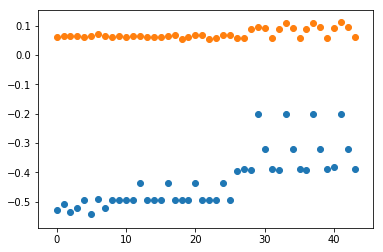

In [17]:
results = np.array(results)
plt.scatter(np.arange(0,len(results)), results[:, 2]-0.8)
plt.scatter(np.arange(0,len(results)), results[:, 3])

In [18]:
results[:,2].argsort()[:5]

array([5, 2, 0, 3, 7])

In [19]:
results[:,3].argsort()[:5]

array([22, 18, 35, 31, 26])

In [20]:
results[5]

array([1.6       , 5.        , 0.25830897, 0.06333804])

In [21]:
isochrone_f = create_isochrone(stars, 1.6, 5)

In [22]:
plt.rcParams.update({'font.size': 12})
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage[utf8]{inputenc}')
plt.rc('text.latex', preamble=r'\usepackage[russian]{babel}')

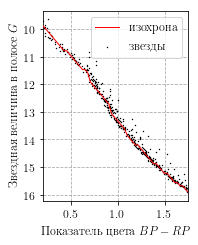

In [23]:
fig, ax = plt.subplots(figsize=(2.6,3.5))
ax.scatter (stars['phot_color_mag'], stars['phot_g_mean_mag'], c ='black', s=2, lw=0, label='звезды', zorder=2)
ax.plot(isochrone_f['bp-rp, mag'],isochrone_f['g, mag'] , c ='red', lw=1,  label ='изохрона', zorder=4)

ax.grid(c='#aaaaaa', ls='--') 
locs, labels = plt.yticks()
locs, labels = plt.xticks()

ax.set_xlim(stars['phot_color_mag'].min(), stars['phot_color_mag'].max())
ax.invert_yaxis()

plt.xlabel('Показатель цвета $BP-RP$')
plt.ylabel('Звездная величина в полосе $G$')
ax.tick_params(axis='both', which='major')
ax.legend()

#plt.savefig( PLOTS_DIRECTORY / f"cmd_approximation_{CLUSTER}.pdf", bbox_inches = 'tight')
plt.show()

## transition to a new coordinate system

In [24]:
func_iso = interp1d(isochrone_f['bp-rp, mag'], isochrone_f['g, mag']) 
stars['Gmag_new'] = stars['phot_g_mean_mag'] - func_iso(stars['phot_color_mag'])

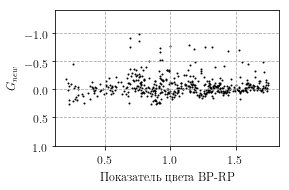

In [25]:
fig, ax = plt.subplots(figsize=(4,2.5))
ax.scatter (stars['phot_color_mag'] , stars['Gmag_new'] , c ='black', s = 1, label ='звезды')

ax.grid(c='#aaaaaa', ls='--') 
locs, labels = plt.yticks()
locs, labels = plt.xticks()

ax.set_ylim(-1.4,1)
ax.invert_yaxis()

plt.xlabel('Показатель цвета BP-RP')
plt.ylabel('$G_{new}$')
ax.tick_params(axis='both', which='major')

plt.savefig(PLOTS_DIRECTORY / f"horizontal_sequence_{CLUSTER}.pdf", bbox_inches = 'tight')
plt.show()

## density profile

In [26]:
num_stars = len(stars)
profile = pd.DataFrame(data = {'x' : np.linspace(-2, 1, 701)})
x = stars['Gmag_new']

# use grid search cross-validation to optimize the bandwidth
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.01, 0.2, 100)}, iid=True, cv=5) 
grid.fit(x[:, None])
bandwidth_opt = sum(grid.best_params_.values())

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [27]:
grid.best_params_

{'bandwidth': 0.04262626262626263}

In [28]:
kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth_opt)

kde.fit(stars[['Gmag_new']].to_numpy())
profile['density'] = np.exp(kde.score_samples(profile[['x']].to_numpy())) * num_stars

Text(0.5, 0, '$G_{new}$')

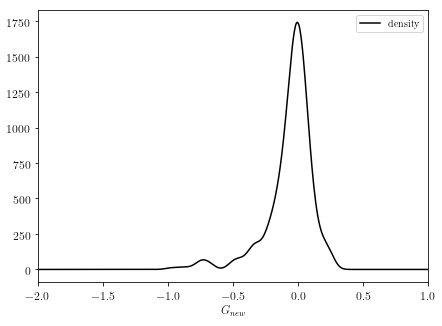

In [29]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(profile['x'], profile['density'], lw = 1.5, color = 'black')
ax.set_xlim(-2, 1)

ax.legend(loc='upper right', fontsize=10)
ax.set_xlabel('$G_{new}$')

## approximation with gauss function

In [30]:
def f(x, a, b, c, d):
    return a * np.exp(-(x - b)**2 / c) + d

row_max = profile['density'].idxmax()
popt, pcov = curve_fit(f, profile.iloc[row_max-35:row_max+155, 0], profile.iloc[row_max-35:row_max+155, 1],
                           bounds=([0, profile.iloc[row_max, 0]-0.1, 0, -0.1],
                                   [5000, profile.iloc[row_max, 0]+0.1, 0.8, 0.1]),
                          maxfev=9000)

profile_gauss = pd.DataFrame(data={'x': profile['x']})
profile_gauss['density'] = f(profile_gauss['x'], *popt)

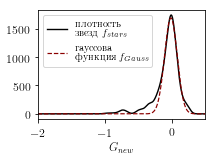

In [33]:
fig, ax = plt.subplots(figsize=(3,2))
ax.plot(profile['x'], profile['density'], lw = 1.4, color = 'black', label='плотность \n звезд $f_{stars}$')
ax.plot(profile_gauss['x'], profile_gauss['density'], lw = 1.2, ls='--', color='darkred', label='гауссова \n функция $f_{Gauss}$')

ax.set_xlim(-2, 0.5)

ax.legend(loc='upper left', fontsize='small')
ax.set_xlabel('$G_{new}$')
fig.savefig(PLOTS_DIRECTORY / f"profile_{CLUSTER}.pdf", bbox_inches = 'tight')

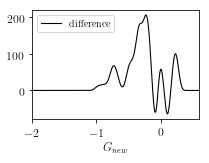

In [34]:
profile['difference'] = profile['density'] - profile_gauss['density']

fig, ax = plt.subplots(figsize=(3,2))
ax.plot(profile['x'], profile['difference'], lw = 1.1, color = 'black')
ax.set_xlim(-2, 0.6)

ax.legend(loc='upper left', fontsize='small')
ax.set_xlabel('$G_{new}$')
fig.savefig(PLOTS_DIRECTORY / f"profile_binaries_{CLUSTER}.pdf", bbox_inches = 'tight')

## estimation of binaries number

In [35]:
mask_below = (profile['difference'] < 0)
mask_left = (profile['x'] > 0)

In [36]:
profile.loc[mask_below & mask_left, 'difference'] = 0

number_of_multiples = int(integrate.trapz(profile['difference'], profile['x']))

In [37]:
# доля двойных из интегрирования профиля
number_of_multiples / len(stars)

0.16455696202531644

In [38]:
# clusters_list = pd.read_excel(MAIN_DIRECTORY / 'cluster_list_data.xlsx', index_col = 0)

In [39]:
# clusters_list.loc[CLUSTER, 'N_binaries'] = number_of_multiples
# clusters_list.loc[CLUSTER, 'N_singles'] = clusters_list.loc[CLUSTER, 'N'] - number_of_multiples
# clusters_list.loc[CLUSTER, 'fraction'] = number_of_multiples / clusters_list.loc[CLUSTER, 'N']

In [32]:
# clusters_list.to_excel(MAIN_DIRECTORY / 'cluster_list_data.xlsx')